## Spoznavanje z okoljem

In [1]:
import pandas as pd
import cobra

from cobra.io import load_model

import numpy as np
import pickle

import os.path 

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML

## *E. coli*

Preberimo model metabolizma *E. coli*. Model smo prenesli s strani http://bigg.ucsd.edu/models/e_coli_core.

In [2]:
model = cobra.io.read_sbml_model(os.path.join('models','e_coli_core.xml'))

In [3]:
model

Name,e_coli_core
Memory address,2420f33b850
Number of metabolites,72
Number of reactions,95
Number of genes,137
Number of groups,0
Objective expression,1.0*BIOMASS_Ecoli_core_w_GAM - 1.0*BIOMASS_Ecoli_core_w_GAM_reverse_712e5
Compartments,"extracellular space, cytosol"


In [7]:
model.reactions[0]

Reaction identifier,PFK
Name,Phosphofructokinase
Memory address,0x2420f02a550
Stoichiometry,"atp_c + f6p_c --> adp_c + fdp_c + h_c ATP C10H12N5O13P3 + D-Fructose 6-phosphate --> ADP C10H12N5O10P2 + D-Fructose 1,6-bisphosphate + H+"
GPR,b3916 or b1723
Lower bound,0.0
Upper bound,1000.0


Nastavimo funkcijo biomase:

In [10]:
model.reactions.get_by_id('BIOMASS_Ecoli_core_w_GAM')

Reaction identifier,BIOMASS_Ecoli_core_w_GAM
Name,Biomass Objective Function with GAM
Memory address,0x2420f58fa10
Stoichiometry,1.496 3pg_c + 3.7478 accoa_c + 59.81 atp_c + 0.361 e4p_c + 0.0709 f6p_c + 0.129 g3p_c + 0.205 g6p_c + 0.2557 gln__L_c + 4.9414 glu__L_c + 59.81 h2o_c + 3.547 nad_c + 13.0279 nadph_c + 1.7867 oaa_c... 1.496 3-Phospho-D-glycerate + 3.7478 Acetyl-CoA + 59.81 ATP C10H12N5O13P3 + 0.361 D-Erythrose 4-phosphate + 0.0709 D-Fructose 6-phosphate + 0.129 Glyceraldehyde 3-phosphate + 0.205 D-Glucose...
GPR,
Lower bound,0.0
Upper bound,1000.0


In [11]:
r_biomass = model.reactions.get_by_id('BIOMASS_Ecoli_core_w_GAM')
r_biomass

Reaction identifier,BIOMASS_Ecoli_core_w_GAM
Name,Biomass Objective Function with GAM
Memory address,0x2420f58fa10
Stoichiometry,1.496 3pg_c + 3.7478 accoa_c + 59.81 atp_c + 0.361 e4p_c + 0.0709 f6p_c + 0.129 g3p_c + 0.205 g6p_c + 0.2557 gln__L_c + 4.9414 glu__L_c + 59.81 h2o_c + 3.547 nad_c + 13.0279 nadph_c + 1.7867 oaa_c... 1.496 3-Phospho-D-glycerate + 3.7478 Acetyl-CoA + 59.81 ATP C10H12N5O13P3 + 0.361 D-Erythrose 4-phosphate + 0.0709 D-Fructose 6-phosphate + 0.129 Glyceraldehyde 3-phosphate + 0.205 D-Glucose...
GPR,
Lower bound,0.0
Upper bound,1000.0


In [12]:
model.objective = r_biomass

In [13]:
model.objective.expression

1.0*BIOMASS_Ecoli_core_w_GAM - 1.0*BIOMASS_Ecoli_core_w_GAM_reverse_712e5

In [14]:
sol = model.optimize()
sol

,fluxes,reduced_costs
PFK,7.477382,0.000000e+00
PFL,0.000000,-1.527746e-02
PGI,4.860861,0.000000e+00
PGK,-16.023526,-0.000000e+00
PGL,4.959985,5.854692e-18
...,...,...
NADH16,38.534610,8.673617e-19
NADTRHD,0.000000,-2.546243e-03
NH4t,4.765319,-3.665630e-17
O2t,21.799493,1.742080e-18


In [15]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
nh4_e,EX_nh4_e,4.765,0,0.00%
o2_e,EX_o2_e,21.8,0,0.00%
pi_e,EX_pi_e,3.215,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-22.81,1,100.00%
h2o_e,EX_h2o_e,-29.18,0,0.00%
h_e,EX_h_e,-17.53,0,0.00%


Rast celice torej znaša 0.874 $h^{-1}$.

Rezultat optimizacije lahko primerjamo z orodjem [Escher-FBA](https://sbrg.github.io/escher-fba/#/app):

In [16]:
sol = model.optimize()
sol['EX_glc__D_e']

-10.0

In [17]:
sol = model.optimize()
sol['EX_o2_e']

-21.79949265599876

### Medij gojenja

Poskusimo spremeniti lastnosti medija. Kot vidimo zgoraj, celica črpa veliko glukoze (pretok je 10 $mmol gDW^{-1} hr^{-1}$ (milimoli na gram suhe celične mase na uro - privzete enote v okolju COBRA)). Kakšen je maksimalen dovod glukoze? Ali celica črpa vse, kar ima na voljo?

In [23]:
r_ex_glc = model.reactions.get_by_id('EX_glc__D_e')
r_ex_glc

Reaction identifier,EX_glc__D_e
Name,D-Glucose exchange
Memory address,0x242105b2d50
Stoichiometry,glc__D_e <=> D-Glucose <=>
GPR,
Lower bound,-10.0
Upper bound,1000.0


Pretok je negativen, ampak reakcija je obrnjena! V orodju COBRA so vse *exchange* (*uptake* in *secretion*) reakcije take oblike. Kot vidimo, celica črpa vso glukozo, ki je na voljo. Poskusimo to zmanjšati:

In [ ]:
r_ex_glc.bounds

In [ ]:
r_ex_glc.bounds = (0, 1000.0)
model.optimize()

Ups. Tole je bilo preveč. 

In [ ]:
r_ex_glc.bounds = (-1.0, 1000.0)

In [ ]:
model.optimize()

Poskusimo analizo ponoviti v anaerobnih pogojih. Nastavili bomo *uptake* kisika:

In [18]:
r_ex_o2 = model.reactions.get_by_id('EX_o2_e')
r_ex_o2

Reaction identifier,EX_o2_e
Name,O2 exchange
Memory address,0x242105c56d0
Stoichiometry,o2_e <=> O2 O2 <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [19]:
#r_ex_glc.bounds = (-10.0, 1000.0)
r_ex_o2.bounds = (0, 1000)

In [21]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,0.3782,1,0.63%
glc__D_e,EX_glc__D_e,10,6,99.37%
h2o_e,EX_h2o_e,7.116,0,0.00%
nh4_e,EX_nh4_e,1.154,0,0.00%
pi_e,EX_pi_e,0.7786,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_e,-8.504,2,33.11%
etoh_e,EX_etoh_e,-8.279,2,32.23%
for_e,EX_for_e,-17.8,1,34.66%
h_e,EX_h_e,-30.55,0,0.00%


Produkcija biomase se je zmanjšala, prav tako pa se je preusmerila pot generiranja energije. Celica tvori in izloča acetat (`ac`), format (`for`) in etanol (`etoh`). Prej je izločala vodo in ogljikov dioksid.

In [ ]:
model.summary()

In [ ]:
s.objective_value

Lahko naredimo analizo produkcije biomase glede na razpoložljivost kisika in glukoze:

In [28]:
o2_max = 1500
glc_max = 1000

# ustvarimo urejen seznam razpon vrednosti kisika in glukoze, za katere želimo narediti analizo
o2_range = np.arange(0, o2_max+1,100)
glc_range = np.arange(0, glc_max+1,100)

# ustvarimo matriko z dvema vrsticama - 1. za kisik, 2. za glukozo
# v vsaki vrstici je toliko ničel kot je število vrednosti, za katere bomo naredili analizo
# ničle se bodo tekom računanja spreminjale v ustrezna števila glede na rezultate analize
B = np.zeros((len(o2_range),len(glc_range)))

# za vsak par vrednosti o2 in glc se bo v matriko vpisal rezultat optimizacije
for i,o2 in enumerate(o2_range):
    for j,glc in enumerate(glc_range):
        r_ex_o2.lower_bound = -o2 # nastavitev spodnje meje reakcij privzema kisika
        r_ex_glc.lower_bound = -glc # nastavitev spodnje meje reakcij prvizema glukoze
        s = model.optimize()
        B[i,j] = s.objective_value # vpis rezultata v matriko

C:\Users\miham\.conda\envs\metabolic\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\miham\.conda\envs\metabolic\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\miham\.conda\envs\metabolic\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\miham\.conda\envs\metabolic\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\miham\.conda\envs\metabolic\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\miham\.conda\envs\metabolic\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is

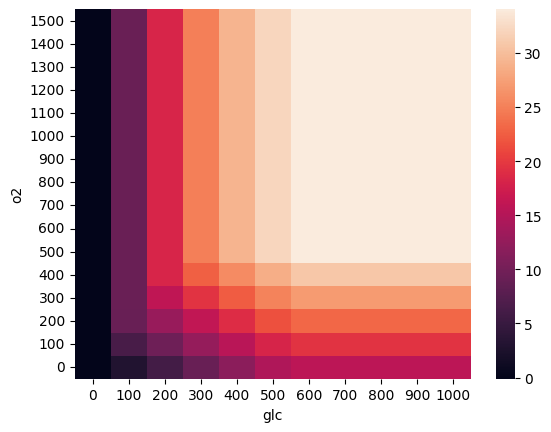

In [29]:
ax = sns.heatmap(B, xticklabels=glc_range, yticklabels=o2_range)
ax.invert_yaxis()
plt.xlabel("glc")
plt.ylabel("o2")
plt.show()

## FVA
FVA (Flux Variability Analysis) omogoča analizo razpona pretokov skozi rekacije pri (skoraj) optimalni produkciji biomase. 

In [30]:
from cobra.flux_analysis import flux_variability_analysis

In [31]:
fva = flux_variability_analysis(model, fraction_of_optimum=0.9, loopless=True)

In [32]:
fva

,minimum,maximum
PFK,356.265728,510.972296
PFL,0.000000,385.309865
PGI,67.205944,522.310700
PGK,-1000.000000,-757.862000
PGL,16.445872,560.689093
...,...,...
NADH16,795.108259,1000.000000
NADTRHD,0.000000,595.977463
NH4t,167.087855,266.791737
O2t,397.554130,500.000000


In [ ]:
model.optimize()
model.summary(fva=0.90)

### Geni v modelu

In [ ]:
for r in model.reactions:
    print(r.gpr)

In [ ]:
model.genes.get_by_id('b4015')

## Recon3D

Preberimo še model Recon3D. Predtem smo ga prenesli s strani [https://github.com/SBRG/Recon3D](https://github.com/SBRG/Recon3D). Opis modela je na voljo v [članku](http://dx.doi.org/10.1038/nbt.4072).

In [33]:
model_rec3d = cobra.io.read_sbml_model(os.path.join('models','Recon3D.xml'))

In [34]:
model_rec3d

Name,Recon3D
Memory address,242133e5290
Number of metabolites,5835
Number of reactions,10600
Number of genes,2248
Number of groups,0
Objective expression,1.0*BIOMASS_maintenance - 1.0*BIOMASS_maintenance_reverse_5b3f9
Compartments,"cytosol, lysosome, mitochondria, endoplasmic reticulum, extracellular space, peroxisome/glyoxysome, nucleus, golgi apparatus, inner mitochondrial compartment"


Poglejmo nekaj atributov modela:

In [36]:
model_rec3d.genes[0]

Gene identifier,0
Name,0
Memory address,0x24210f2f810
Functional,True
In 1 reaction(s),HDCA24Gtr


In [37]:
model_rec3d.metabolites[:3]

[<Metabolite 10fthf_c at 0x242133aaf50>,
 <Metabolite 10fthf_l at 0x24210ff0610>,
 <Metabolite 10fthf_m at 0x24210ed29d0>]

In [38]:
model_rec3d.reactions[:3]

[<Reaction 24_25DHVITD3tm at 0x2421326b3d0>,
 <Reaction 25HVITD3t at 0x2423ebfff50>,
 <Reaction COAtl at 0x2423ec00790>]

Povzetek modela lahko dobimo z metodo [summary](https://cobrapy.readthedocs.io/en/latest/autoapi/cobra/summary/model_summary/index.html):

In [39]:
model_rec3d.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
thmtp_c,DM_thmtp_c,1000,12,4.09%
12ppd__R_e,EX_12ppd__R_e,250.8,3,0.26%
5aop_e,EX_5aop_e,1000,5,1.70%
HC00250_e,EX_HC00250_e,1000,0,0.00%
HC00900_e,EX_HC00900_e,1000,4,1.36%
HC01361_e,EX_HC01361_e,1000,9,3.07%
Lkynr_e,EX_Lkynr_e,105.1,10,0.36%
acetone_e,EX_acetone_e,427.7,3,0.44%
alltn_e,EX_alltn_e,1000,4,1.36%
atp_e,EX_atp_e,1000,10,3.41%


In [40]:
for r in model_rec3d.reactions[:100]:
    gpr = r.gene_reaction_rule
    if gpr:
        print(gpr)

1591_AT1
8639_AT1 or 26_AT1 or 314_AT2 or 314_AT1
1594_AT1
10993_AT1
6818_AT1
89874_AT1
(4967_AT2 and 1738_AT1 and 8050_AT1 and 1743_AT1) or (4967_AT1 and 1738_AT1 and 8050_AT1 and 1743_AT1)
89874_AT1
117247_AT1
221_AT1 or 218_AT1 or 220_AT1
18_AT1 or 18_AT2
23498_AT1
4128_AT1 or 4129_AT1
4129_AT1 or 8639_AT1 or 26_AT1 or 314_AT2 or 314_AT1 or 4128_AT1
222_AT1 or 220_AT1 or 221_AT1 or 218_AT1
6799_AT1 or 6817_AT3 or 6799_AT2 or 6818_AT2 or 6817_AT2 or 6818_AT1 or 6817_AT1 or 6817_AT4 or 6818_AT3 or 6817_AT5
6822_AT1 or 6818_AT1
6573_AT1 or 6573_AT2
4128_AT1 or 4129_AT1
53947_AT1
53947_AT1
51146_AT1
28_AT1
28_AT1
28_AT1
28_AT1
28_AT1
28_AT1
18_AT1 or 18_AT2
206358_AT1
38_AT1 or 3032_AT1 or 10449_AT1
30_AT1
30_AT1
30_AT1
84532_AT1 or 79611_AT1
9197_AT1
6566_AT1 or 9123_AT1 or 9194_AT1
55577_AT1
5238_AT1
6572_AT1
26503_AT1
36_AT1 or 34_AT1
3712_AT1
34_AT1 or 27034_AT1
51_AT1 or 51_AT2
95_AT1
50_AT1 or 48_AT1
52_AT1 or 52_AT3 or 52_AT2 or 55_AT1 or 51205_AT1 or 54_AT1
55902_AT1 or 65985_AT

In [41]:
g = model_rec3d.genes.get_by_id('55902_AT1')
g

Gene identifier,55902_AT1
Name,ACSS2
Memory address,0x2423e7b6dd0
Functional,True
In 9 reaction(s),"r0319, r0068, r0220_1, ACS, r0097, r0318, r0221_1, ACCOAL, ACS2"


Izpišimo gene v padajočem vrstnem redu glede na število reakcij, v katerih nastopajo.

In [42]:
d = {}

for g in model_rec3d.genes:
    d[g.name] = len(g.reactions)

In [43]:
G = sorted(list(d.items()), key=lambda x: x[1], reverse = True)
G[:30]

[('SLC7A6', 307),
 ('SLC15A1', 252),
 ('SLC15A2', 243),
 ('HADHA', 168),
 ('EHHADH', 166),
 ('SLCO1B1', 148),
 ('SLC27A2', 123),
 ('ACSL1', 122),
 ('ACAA1', 116),
 ('SLC7A5', 115),
 ('SLCO1A2', 106),
 ('HADHB', 105),
 ('CPT1A', 103),
 ('ACOX1', 100),
 ('ACADM', 98),
 ('HSD17B4', 98),
 ('ACSL5', 96),
 ('ACSBG2', 93),
 ('ACSL6', 93),
 ('CPT1C', 92),
 ('SLC25A20', 91),
 ('ABCA1', 90),
 ('SLC7A9', 86),
 ('ECHS1', 84),
 ('HADH', 81),
 ('ACADVL', 80),
 ('SLC16A1', 78),
 ('ACAA2', 77),
 ('ACSBG1', 76),
 ('BAAT', 73)]